Idea: Make the premium betewen IV and RV, via a variance swap

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  5 of 5 completed


KeyError: 'HY_OAS'

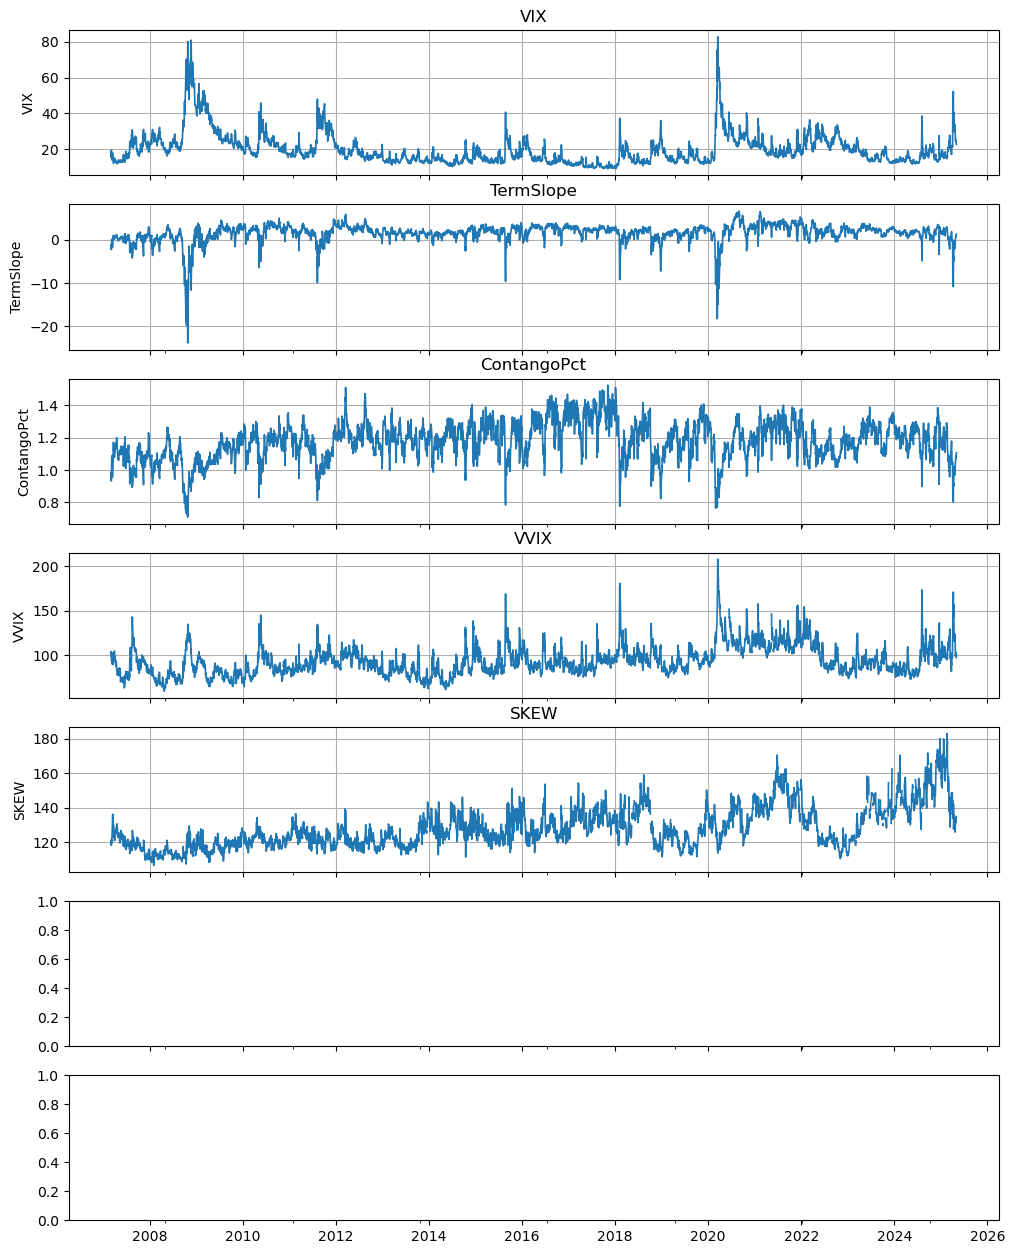

In [1]:
import yfinance as yf
import pandas_datareader.data as web
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# ------------------------------------------------------------
# 1. Set the date range
# ------------------------------------------------------------
start, end = "2024-03-01", "2025-5-5"
start_new, end_new = "2007-03-01", "2025-5-5"
# ------------------------------------------------------------
# 2. Download VIX complex & option-side indices from Yahoo
# ------------------------------------------------------------
ticker_map = {
    "VIX": "^VIX",            # 30-day implied vol
    "VIX9D": "^VIX9D",        # 9-day implied vol (proxy for front-end)
    "VIX3M": "^VIX3M",        # 3-month VIX
    "VVIX": "^VVIX",          # vol-of-vol
    "SKEW": "^SKEW",          # CBOE tail skew index
}

yahoo = yf.download(list(ticker_map.values()), start=start_new, end=end_new, interval='1D')['Close']
yahoo = yahoo.rename(columns={v: k for k, v in ticker_map.items()})
# ------------------------------------------------------------
# 3. Compute *term-structure slope* (VIX3M – VIX) and 0-to-30-day
#    contango (% difference) as simple indicators
# ------------------------------------------------------------
indic = pd.DataFrame(index=yahoo.index)
indic["VIX"]           = yahoo["VIX"]
indic["TermSlope"]     = yahoo["VIX3M"] - yahoo["VIX"]        # absolute pts
indic["ContangoPct"]   = (yahoo["VIX3M"] / (yahoo["VIX"] - 1))  # %
indic["VVIX"]          = yahoo["VVIX"]
indic["SKEW"]          = yahoo["SKEW"]

# ------------------------------------------------------------
# 4. Pull credit & funding-stress series from FRED
#    (ICE BofA High-Yield OAS and TED spread)
# ------------------------------------------------------------
fred_series = {
    "HY_OAS": "BAMLH0A0HYM2",   # ICE BofA High-Yield Option-Adj Spread (%)
    "TED":    "TEDRATE",        # 3-m LIBOR – 3-m T-bill (%)
}

# fred = web.DataReader(list(fred_series.values()), "fred", start, end)
# fred.columns = fred_series.keys()

# indic = indic.join(fred, how="left").fillna(method="ffill")

# ------------------------------------------------------------
# 5. Plot: one figure per signal for clear comparison
# ------------------------------------------------------------
plt.style.use("default")
signals = ["VIX", "TermSlope", "ContangoPct", "VVIX", "SKEW", "HY_OAS", "TED"]

fig, axes = plt.subplots(len(signals), 1, figsize=(12, 2.5 * len(signals)), sharex=True)

for i, sig in enumerate(signals):
    ax = axes[i]
    indic[sig].plot(ax=ax, lw=1.2)
    ax.set_ylabel(sig)
    ax.grid(True)
    ax.set_title(sig)

plt.suptitle(f"Market Stress Indicators  ·  {start} → {end}", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Leave space for suptitle
plt.show()

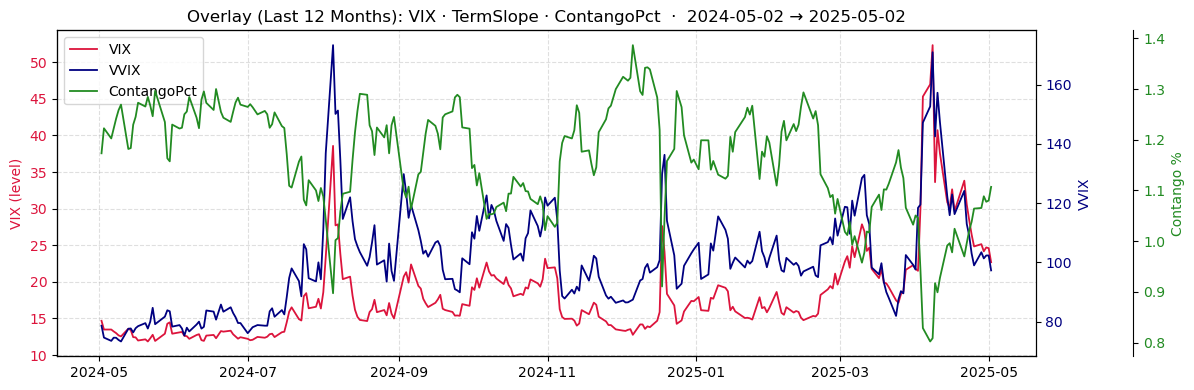

In [2]:
last_date = indic.index.max()
start_1y  = last_date - pd.DateOffset(years=1)

vix_1y        = indic["VIX"].loc[start_1y:]
vvix_1y      = indic["VVIX"].loc[start_1y:]
contango_1y   = indic["ContangoPct"].loc[start_1y:]

# ── 1 ▸ overlay plot ──────────────────────────────────────────
fig, ax1 = plt.subplots(figsize=(12, 4))

# VIX  (left axis)
ax1.plot(vix_1y.index, vix_1y, color="crimson", lw=1.3, label="VIX")
ax1.set_ylabel("VIX (level)", color="crimson")
ax1.tick_params(axis="y", labelcolor="crimson")
ax1.grid(True, which="both", ls="--", alpha=0.4)

# TermSlope  (first right axis)
ax2 = ax1.twinx()
ax2.plot(vvix_1y.index, vvix_1y, color="navy", lw=1.3, label="VVIX")
ax2.set_ylabel("VVIX", color="navy")
ax2.tick_params(axis="y", labelcolor="navy")

# ContangoPct  (second right axis, offset)
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.1))
ax3.plot(contango_1y.index, contango_1y, color="forestgreen", lw=1.3,
         label="ContangoPct")
ax3.set_ylabel("Contango %", color="forestgreen")
ax3.tick_params(axis="y", labelcolor="forestgreen")

# Title & legend
title_range = f"{start_1y.date()} → {last_date.date()}"
ax1.set_title(f"Overlay (Last 12 Months): VIX · TermSlope · ContangoPct  ·  {title_range}")

handles = ax1.get_lines() + ax2.get_lines() + ax3.get_lines()
labels  = [h.get_label() for h in handles]
ax1.legend(handles, labels, loc="upper left")

plt.tight_layout()
plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


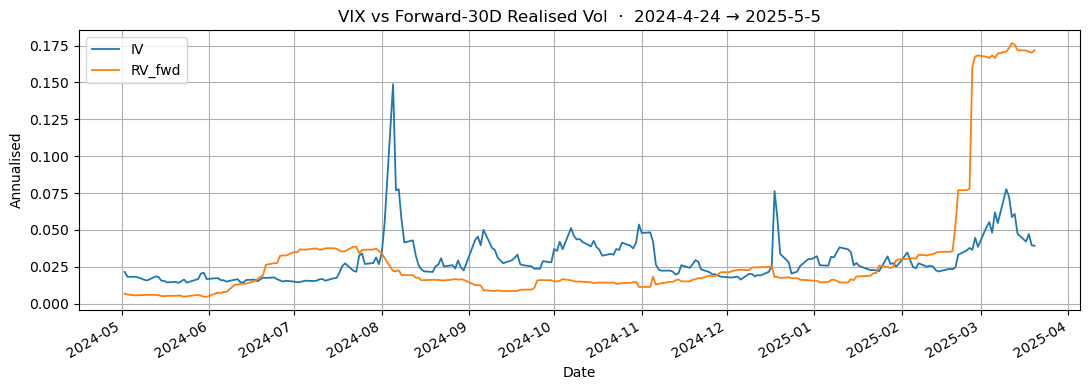

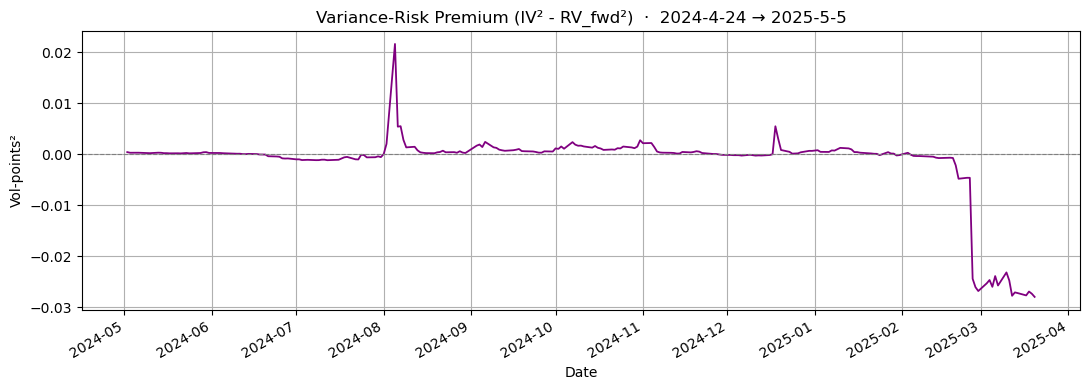

In [ ]:
spx = yf.download("^GSPC", start=start_new, end=end_new, interval='1d')['Close'].dropna()
#log returns 
rets = spx.pct_change().dropna()


# realised vol for *next* 30 trading days: roll then shift *back* 29 steps
rv_fwd_30d = (
    rets.rolling(window=30, min_periods=30)
        .std(ddof=0)
        .shift(-30)               # align with VIX date t
        * (252 ** 0.5)            # annualise
)
rv_fwd_30d.name = "RV_fwd"

vix = yf.download("^VIX", start=start_new, end=end_new, interval='1D')['Close']
# ------------------------------------------------------------
# 7.  Align IV (VIX) and forward RV; compute VRP
# ------------------------------------------------------------

vol_df          = pd.concat([(vix/100), rv_fwd_30d], axis=1).dropna()
vol_df.columns  = ["IV", "RV_fwd"]
vol_df["VRP"]   = (vol_df["IV"] ** 2) - (vol_df["RV_fwd"] ** 2)

start_1y = last_date - pd.DateOffset(years=1)
vol_plot = vol_df.loc[start_1y:]
# ------------------------------------------------------------
# 8.  Plots
# ------------------------------------------------------------
plt.style.use("default")

# (a) IV vs *forward* RV
fig, ax = plt.subplots(figsize=(11, 4))
vol_plot[["IV", "RV_fwd"]].plot(ax=ax, lw=1.3)
ax.set_title(f"VIX vs Forward-30D Realised Vol  ·  2024-4-24 → {end_new}")
ax.set_ylabel("Annualised")
ax.grid(True)
plt.tight_layout()

# (b) Variance-risk premium (forward definition)
fig, ax = plt.subplots(figsize=(11, 4))
vol_plot["VRP"].plot(ax=ax, color="purple", lw=1.3)
ax.axhline(0, color="gray", ls="--", lw=0.8)
ax.set_title(f"Variance-Risk Premium (IV² - RV_fwd²)  ·  2024-4-24 → {end_new}")
ax.set_ylabel("Vol-points²")
ax.grid(True)
plt.tight_layout()

plt.show()

Problem: Variance-Risk Premium earned during low volatile periods could be easily offset by tail events when RV > IV. 

Idea: to design a Markov Switching model that detects volatility regimes with a probability. This allows us to switch positions/hedge in anticipation of a switch of regime.

Data to consider: VVIX, SPY Option Term structure, VIX Future Term structure, cointegration, SKEW, etc..

First strat: variance swap that earns Variance-Risk premium.
Second strat: Future shorting during contango (also earns risk premium)

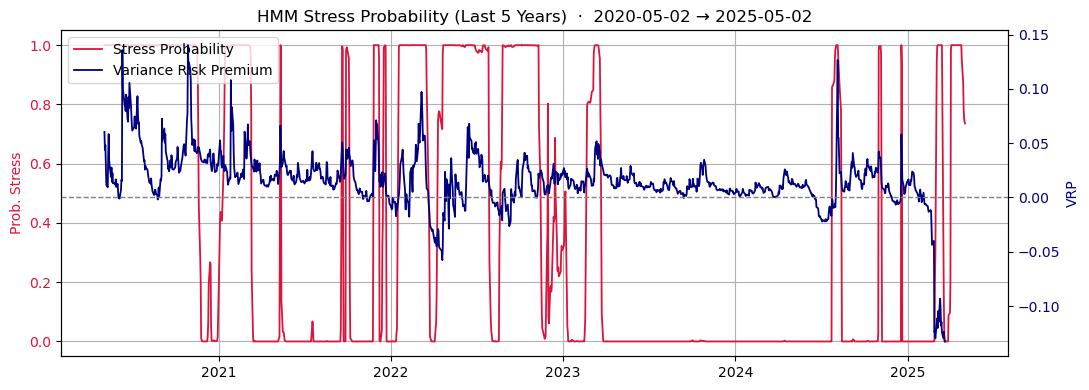

In [8]:
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler
import numpy as np


# ------------------------------------------------------------
# 1.  Assemble feature matrix (returns + vol signals)
# ------------------------------------------------------------
rets_pct = 100 * spx.pct_change()            # Series of % returns
rets_df = rets_pct.rename(columns={"^GSPC": "ret"}).dropna()    # give it a column name

feature_cols = ["TermSlope", "ContangoPct", "VVIX", "SKEW"]
features = pd.concat([rets_df, indic[feature_cols]], axis=1).dropna()

last_date = features.index.max()
new_end_date = last_date - pd.DateOffset(years=5)
features_reduced = features.loc[:new_end_date]

# standardise for HMM fit (but keep an un-scaled copy of returns)
sc = StandardScaler()
X  = sc.fit_transform(features_reduced)

# ------------------------------------------------------------
# 2.  Fit Gaussian HMM
# ------------------------------------------------------------
hmm = GaussianHMM(
    n_components=2,
    covariance_type="full",
    n_iter=1000,
    random_state=1
)
hmm.fit(X)

X_full = sc.fit_transform(features)
states = hmm.predict(X_full)               # length == len(features)
post   = hmm.predict_proba(X_full)

# ------------------------------------------------------------
# 3.  Identify which component is 'Stress'
#     (higher variance of *the same* returns vector you fed in)
# ------------------------------------------------------------
ret_arr        = features["ret"].values                  # aligned, length=N
state_ret_var  = [ret_arr[states == k].var() for k in range(2)]
stress_state   = int(np.argmax(state_ret_var))           # 0 or 1
stress_prob    = pd.Series(post[:, stress_state], index=features.index)

# ------------------------------------------------------------
# 4.  Plot
# ------------------------------------------------------------
last_date = stress_prob.index.max()
start_5y = last_date - pd.DateOffset(years=5)

# Filter the data
stress_prob_5y = stress_prob.loc[start_5y:]
vrp_5y = vol_df["VRP"].loc[start_5y:]

# Plot
fig, ax1 = plt.subplots(figsize=(11, 4))

# Plot stress probability on the left axis
ax1.plot(stress_prob_5y.index, stress_prob_5y.values, color="crimson", lw=1.3, label="Stress Probability")
ax1.set_title(f"HMM Stress Probability (Last 5 Years)  ·  {start_5y.date()} → {last_date.date()}")
ax1.set_ylabel("Prob. Stress", color="crimson")
ax1.set_ylim(-0.05, 1.05)
ax1.tick_params(axis='y', labelcolor="crimson")
ax1.grid(True)

# Create a second y-axis for the Variance Risk Premium
ax2 = ax1.twinx()
ax2.plot(vrp_5y.index, vrp_5y.values, color="navy", lw=1.3, label="Variance Risk Premium")
ax2.set_ylabel("VRP", color="navy")
ax2.tick_params(axis='y', labelcolor="navy")

# Add horizontal line at y=0 on the VRP axis
ax2.axhline(0, color="gray", linestyle="--", linewidth=1)

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.tight_layout()
plt.show()

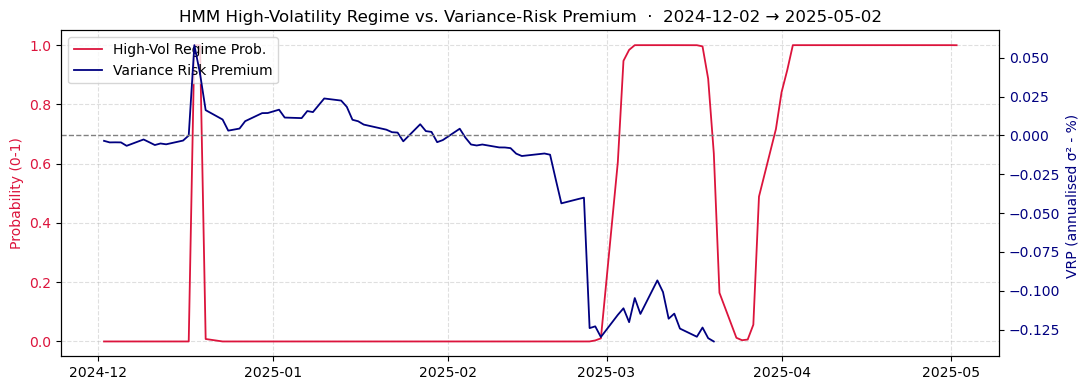

In [9]:
vix_lvl   = indic["VIX"].rename("VIX_lvl")
vix_ret   = indic["VIX"].pct_change().rename("VIX_ret")              # daily %
vix_roll  = vix_ret.rolling(5).mean().rename("VIX_ret_5d")           # short-term trend
vvix_lvl  = indic["VVIX"].rename("VVIX_lvl")                         # vol-of-vol
term_slope   = indic["TermSlope"]                                    # VIX3M − VIX
contango_pct = indic["ContangoPct"]
skew_idx     = indic["SKEW"]

# Combine
features_vix = pd.concat(
    [vix_lvl, vix_roll, 
     contango_pct, skew_idx],
    axis=1
).dropna()

features_vix_reduced = features_vix.loc[:new_end_date]
# ── 2. Standardise ────────────────────────────────────────────
sc = StandardScaler()
X_vix = sc.fit_transform(features_vix_reduced)

# ── 3. Fit Gaussian-HMM ───────────────────────────────────────

hmm = GaussianHMM(
    n_components=2,          # or 3, try both
    covariance_type="full",
    n_iter=50,
    random_state=1
)
hmm.fit(X_vix)

X_full = sc.fit_transform(features_vix)
states       = hmm.predict(X_full)
posteriors   = hmm.predict_proba(X_full)

# ── 4. Decide which state is "High-Vol regime" ────────────────
# Use mean VIX level inside each state:
vix_in_model = features_vix["VIX_lvl"].values          # same length as X_vix
state_mean_vix = [vix_in_model[states == k].mean()
                  for k in range(hmm.n_components)]
hv_state = int(np.argmax(state_mean_vix))          # index of high-vol state
hv_prob  = pd.Series(posteriors[:, hv_state], index=features_vix.index)




# ── 1 ▸ slice to the most-recent five-year window ──────────────────────────────
last_date = hv_prob.index.max()          # assumes hv_prob is a Series
start_5y  = last_date - pd.DateOffset(months=5)

hv_prob_5y = hv_prob.loc[start_5y:]      # hidden-vol regime probability
vrp_5y     = vol_df["VRP"].loc[start_5y:] # variance-risk premium

# ── 2 ▸ plot twin-axis chart ───────────────────────────────────────────────────
fig, ax1 = plt.subplots(figsize=(11, 4))

# left axis – high-vol regime probability
ax1.plot(hv_prob_5y.index, hv_prob_5y.values,
         color="crimson", lw=1.3, label="High-Vol Regime Prob.")
ax1.set_ylabel("Probability (0-1)", color="crimson")
ax1.set_ylim(-0.05, 1.05)
ax1.tick_params(axis="y", labelcolor="crimson")
ax1.grid(True, which="both", linestyle="--", alpha=0.4)

# right axis – variance-risk premium
ax2 = ax1.twinx()
ax2.plot(vrp_5y.index, vrp_5y.values,
         color="navy", lw=1.3, label="Variance Risk Premium")
ax2.set_ylabel("VRP (annualised σ² - %) ", color="navy")
ax2.tick_params(axis="y", labelcolor="navy")
ax2.axhline(0, color="gray", ls="--", lw=1)

# titles & legend
title_range = f"{start_5y.date()} → {last_date.date()}"
ax1.set_title(f"HMM High-Volatility Regime vs. Variance-Risk Premium  ·  {title_range}")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.tight_layout()
plt.show()

training code, toy with different data settings to train hmm

/var/folders/0x/zwgfp4q901n8zf_7k08m5wp80000gn/T/ipykernel_98882/1987845527.py:105: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  ax1.legend(handles, labels, loc="upper left")


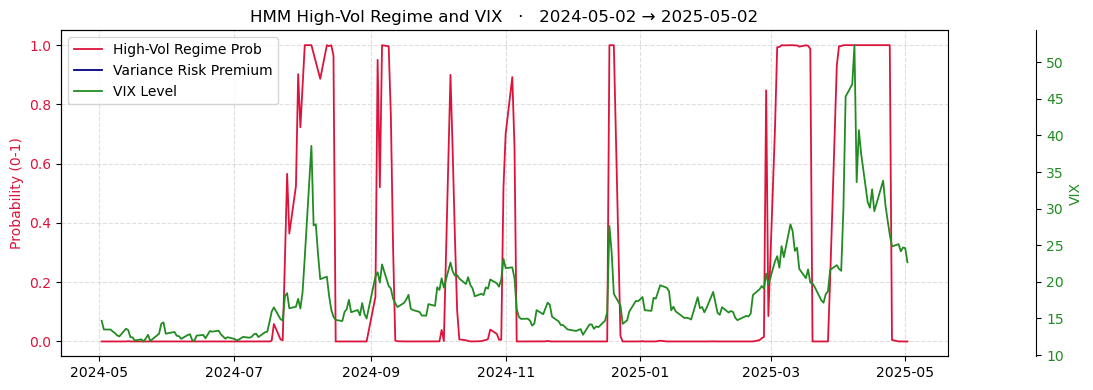

In [10]:
# ---- 0. parameters ----------------------------------------------------------
window  = 20            # look-back length (can tune)
n_sigma = 2.0           # band width

# ---- 1. base series ---------------------------------------------------------
vix   = indic["VIX"]
vvix  = indic["VVIX"]

# ---- 2. rolling mean & stdev -----------------------------------------------
vix_ma   = vix.rolling(window).mean()
vix_std  = vix.rolling(window).std(ddof=0)
vvix_ma  = vvix.rolling(window).mean()
vvix_std = vvix.rolling(window).std(ddof=0)

# ---- 3. Bollinger z-scores --------------------------------------------------
vix_z   = ((vix - vix_ma)   / vix_std).rename("VIX_BBz")     # ~ −∞…+∞
vvix_z  = ((vvix - vvix_ma) / vvix_std).rename("VVIX_BBz")

thr_vix, thr_vvix = -0.75, -0.50

low_vol_trigger = (
    (vix_z  <= thr_vix) &
    (vvix_z <= thr_vvix)
).astype(int)                     # 1 = BOTH indices in “low” zone
low_vol_trigger.name = "double_low_flag"

# ---- 4. dispersion (VVIX_z − VIX_z) ----------------------------------------
dispersion = (vvix_z - vix_z).rename("Disp_VVIX-VIX")

# ---- 5. merge into your VIX-feature set -------------------------------------
features_vix = pd.concat(
    [features_vix, dispersion, low_vol_trigger],
    axis=1
).dropna() 

start_5y  = last_date - pd.DateOffset(years=5)
new_end_date = last_date - pd.DateOffset(years=5)
features_train  = features_vix.loc[:new_end_date]          # 15 y
features_test   = features_vix.loc[start_5y:]              # 3 y

sc   = StandardScaler().fit(features_train)                # fit once
X_tr = sc.transform(features_train)
X_te = sc.transform(features_test)

hmm = GaussianHMM(n_components=2, covariance_type="full",
                  n_iter=5000, random_state=1).fit(X_tr)

# ---------- filtered (forward-only) probabilities ----------
filtered_p = []
for i in range(len(X_te)):
    # forward pass uses data ≤ i
    p_i = hmm.predict_proba(X_te[: i + 1])[-1]
    filtered_p.append(p_i)
filtered_p = np.vstack(filtered_p)                         # shape (T, 2)

# ---------- map state-id → “high-vol” ----------------------
states_full = hmm.predict(X_te)                            # Viterbi (just for labelling)
state_mean_vix = [
    features_test["VIX_lvl"].values[states_full == k].mean()
    for k in range(hmm.n_components)
]
hv_state = int(np.argmax(state_mean_vix))                  # index of hi-vol regime
hv_prob  = pd.Series(filtered_p[:, hv_state],
                     index=features_test.index,
                     name="hv_prob")

# ------------------------------------------------------------
# 2 ▸  PREP series for the plot (same 5-y window)
# ------------------------------------------------------------
vrp_5y = vol_df["VRP"].loc[start_5y:]
vix_5y = indic["VIX"].loc[start_5y:]

# ------------------------------------------------------------
# 3 ▸  PLOT  ·  hv_prob  vs.  VRP  &  VIX  (triple axis)
# ------------------------------------------------------------
fig, ax1 = plt.subplots(figsize=(11, 4))
start_1y = last_date - pd.DateOffset(months=12)
# left axis – high-vol regime probability
ax1.plot(hv_prob.loc[start_1y:], color="crimson", lw=1.3, label="High-Vol Regime Prob")
ax1.set_ylabel("Probability (0-1)", color="crimson")
ax1.set_ylim(-0.05, 1.05)
ax1.tick_params(axis="y", labelcolor="crimson")
ax1.grid(ls="--", alpha=0.4)

# # right axis #1 – VRP
# ax2 = ax1.twinx()
# ax2.plot(vrp_5y.loc[start_1y:], color="navy", lw=1.3, label="Variance Risk Premium")
# ax2.set_ylabel("VRP (ann. σ² %)", color="navy")
# ax2.tick_params(axis="y", labelcolor="navy")
# ax2.axhline(0, ls="--", lw=1, color="gray")

# right axis #2 – VIX (offset outward)
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.10))
ax3.plot(vix_5y.loc[start_1y:], color="forestgreen", lw=1.3, label="VIX Level")
ax3.set_ylabel("VIX", color="forestgreen")
ax3.tick_params(axis="y", labelcolor="forestgreen")

# title & consolidated legend
title_range = f"{start_1y.date()} → {hv_prob.index.max().date()}"
ax1.set_title(f"HMM High-Vol Regime and VIX   ·   {title_range}")

handles = ax1.get_lines() + ax2.get_lines() + ax3.get_lines()
labels  = [h.get_label() for h in handles]
ax1.legend(handles, labels, loc="upper left")

plt.tight_layout()
plt.show()

loading from trained model, plotting + backtesting section

In [12]:
import joblib          # or use the built-in pickle module
#joblib.dump(hmm, "hmm_vix_model_4.0.pkl")

In [17]:
hmm_loaded = joblib.load("hmm_vix_model_3.0.pkl")

filtered_p = []
for i in range(len(X_te)):
    # forward pass uses data ≤ i
    p_i = hmm_loaded.predict_proba(X_te[: i + 1])[-1]
    filtered_p.append(p_i)
filtered_p = np.vstack(filtered_p)                         # shape (T, 2)

# ---------- map state-id → “high-vol” ----------------------
states_full = hmm_loaded.predict(X_tr)                            # Viterbi (just for labelling)
state_mean_vix = [
    features_train["VIX_lvl"].values[states_full == k].mean()
    for k in range(hmm_loaded.n_components)
]
hv_state = int(np.argmax(state_mean_vix))                  # index of hi-vol regime
hv_prob  = pd.Series(filtered_p[:, hv_state],
                     index=features_test.index,
                     name="hv_prob")

print(state_mean_vix)
print(hv_state)
# ------------------------------------------------------------
# 2 ▸  PREP series for the plot (same 5-y window)
# ------------------------------------------------------------
# vrp_5y = vol_df["VRP"].loc[start_5y:]
# vix_5y = indic["VIX"].loc[start_5y:]


# ── 1 ▸ slice to the most-recent five-year window ──────────────────────────────
last_date = hv_prob.index.max()          # assumes hv_prob is a Series
start_5y  = last_date - pd.DateOffset(months=50)

hv_prob_5y = hv_prob.loc[start_5y:]      # hidden-vol regime probability
vrp_5y     = vol_df["VRP"].loc[start_5y:] # variance-risk premium
vix_5y = indic["VIX"].loc[start_5y:]

[15.160181338552366, 26.671854397711627]
1


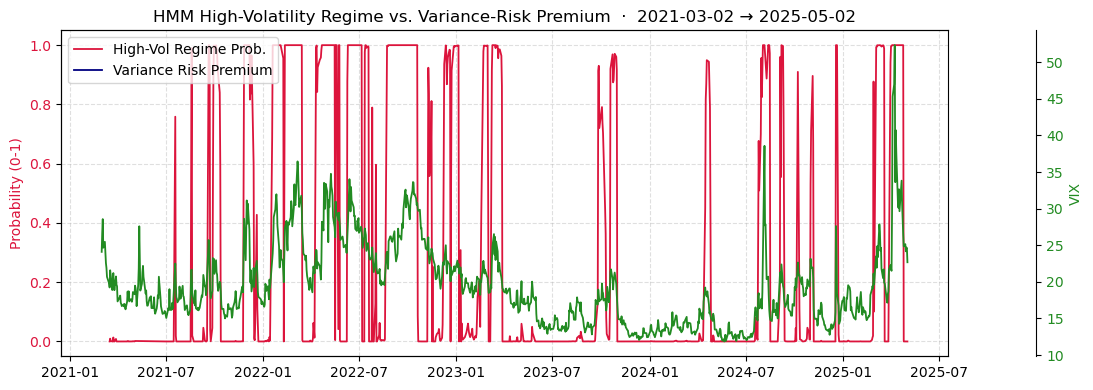

In [14]:
fig, ax1 = plt.subplots(figsize=(11, 4))
# left axis – high-vol regime probability
ax1.plot(hv_prob_5y.index, hv_prob_5y.values,
         color="crimson", lw=1.3, label="High-Vol Regime Prob.")
ax1.set_ylabel("Probability (0-1)", color="crimson")
ax1.set_ylim(-0.05, 1.05)
ax1.tick_params(axis="y", labelcolor="crimson")
ax1.grid(True, which="both", linestyle="--", alpha=0.4)

ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.10))
ax3.plot(vix_5y, color="forestgreen", lw=1.3, label="VIX Level")
ax3.set_ylabel("VIX", color="forestgreen")
ax3.tick_params(axis="y", labelcolor="forestgreen")

#right axis – variance-risk premium
# ax2 = ax1.twinx()
# ax2.plot(vrp_5y.index, vrp_5y.values, color="navy", lw=1.3, label="Variance Risk Premium")
# ax2.set_ylabel("VRP", color="navy")
# ax2.tick_params(axis='y', labelcolor="navy")

# titles & legend
title_range = f"{start_5y.date()} → {last_date.date()}"
ax1.set_title(f"HMM High-Volatility Regime vs. Variance-Risk Premium  ·  {title_range}")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.tight_layout()
plt.show()

With this model for generating signals, we now turn this into a trading strategy, involving both the variance swap (during calm periods), longs (during 0->1) and shorts (during (1->0)), and reduction and increase of variance swap accordingly. 

We first generate the strategy first, next we try to tweek the signal for each of the actions for risk management purposes

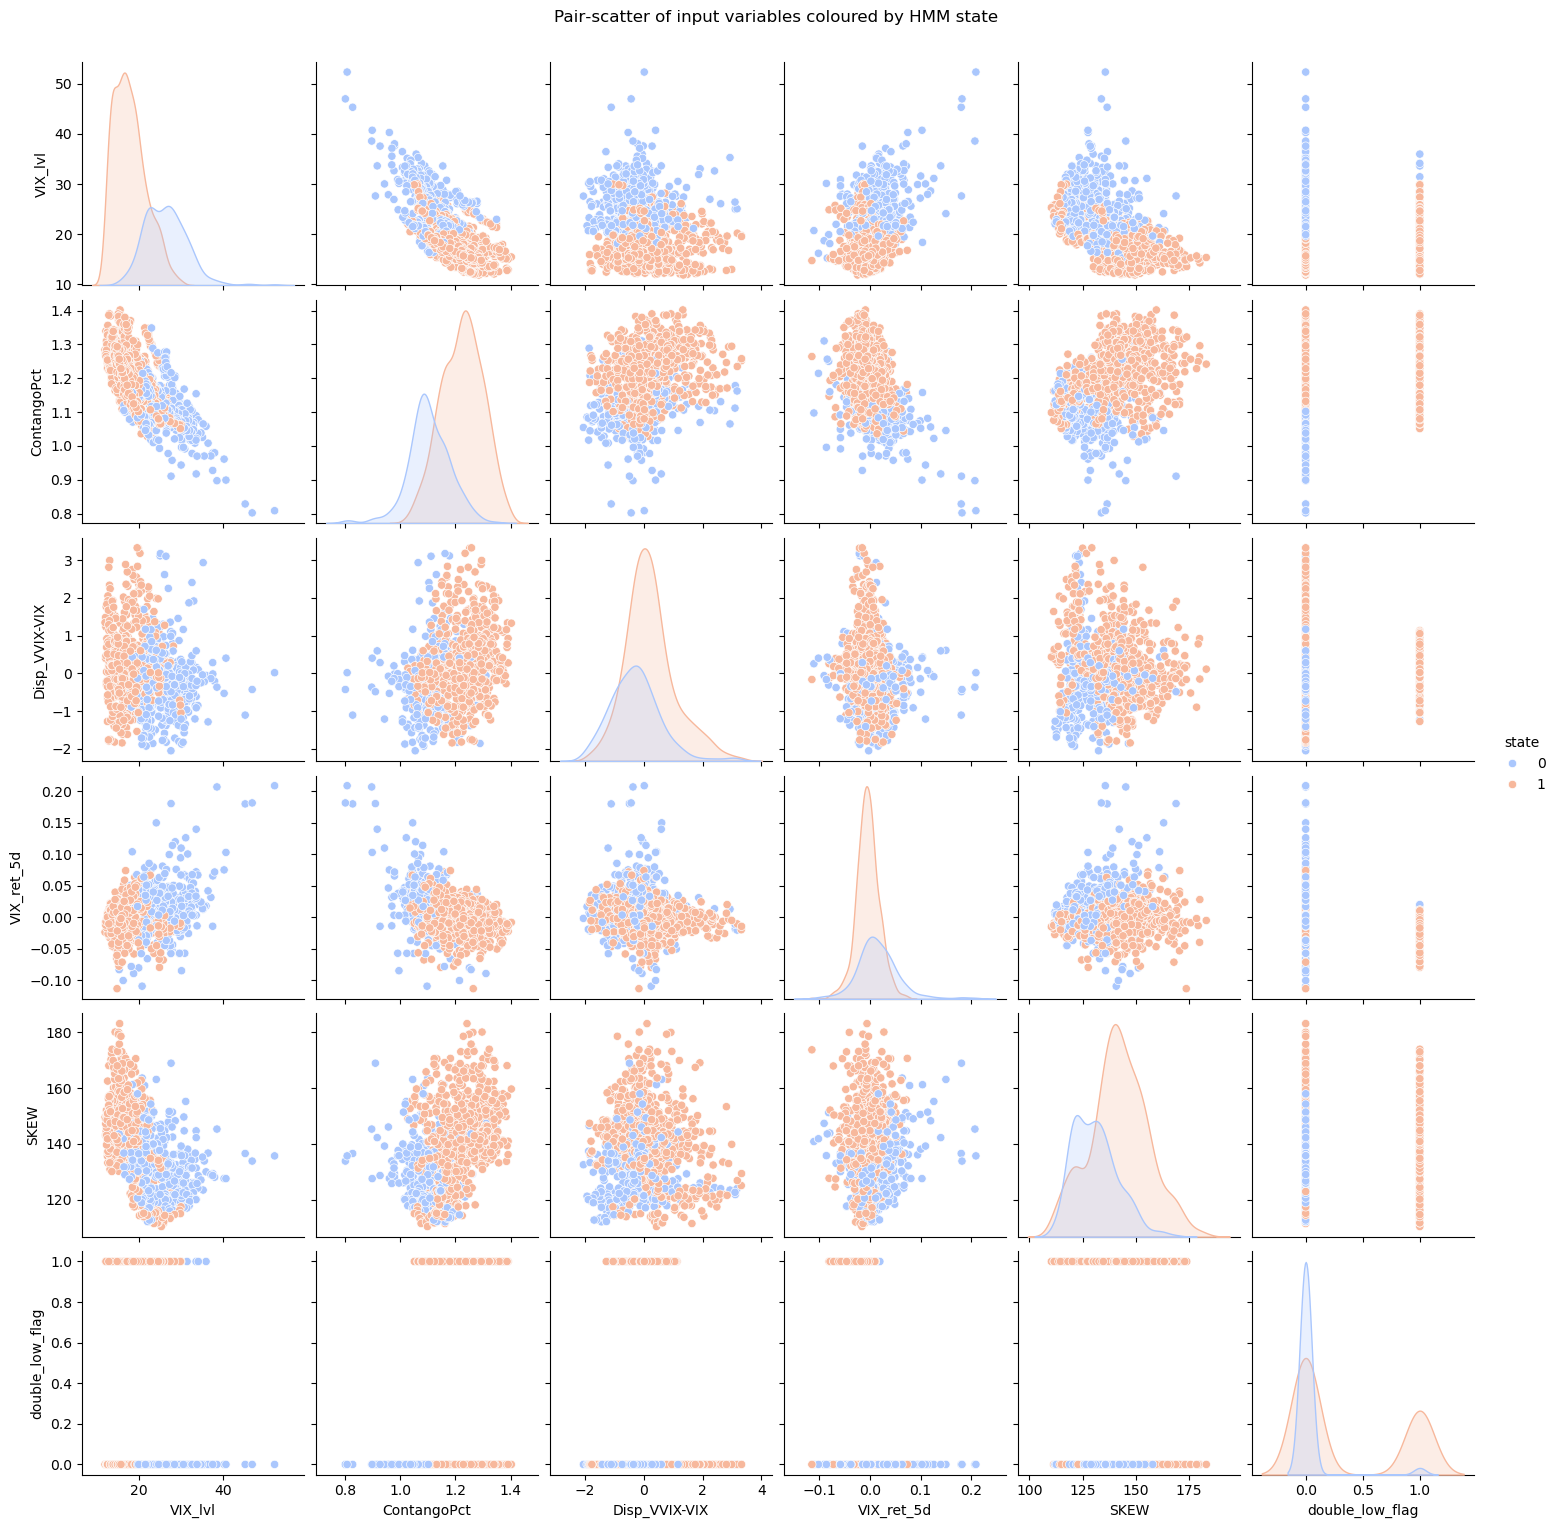

In [18]:
import seaborn as sns      # conda/pip install seaborn if needed
sel_cols = ["VIX_lvl", "ContangoPct",
            "Disp_VVIX-VIX", "VIX_ret_5d", "SKEW", "double_low_flag"]          # pick 4–7 vars

plot_df = features_test.copy()

states_full_test = hmm.predict(X_te)   
plot_df["state"] = states_full_test          # 0 = calm, 1 = stress  (Viterbi path)

sns.pairplot(plot_df[sel_cols + ["state"]],
             hue="state", palette="coolwarm", diag_kind="kde")
plt.suptitle("Pair‑scatter of input variables coloured by HMM state", y=1.02)
plt.show()

Daily Sharpe (ann.):  1.05
Final realised P&L : $5,624,764
Open contracts     : 0
Ticker
^GSPC    0.734649
dtype: float64


/var/folders/0x/zwgfp4q901n8zf_7k08m5wp80000gn/T/ipykernel_98882/3087619537.py:266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .fillna(0)


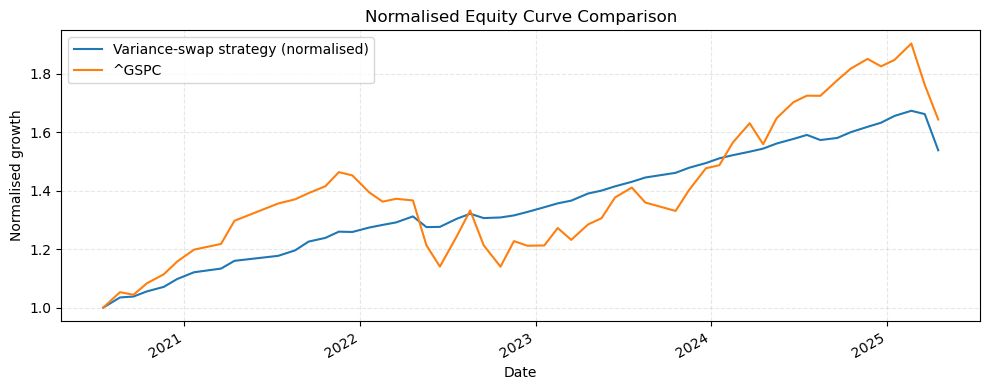

In [315]:
import math
import pandas as pd
import matplotlib.pyplot as plt

import glob
import pandas as pd
from pathlib import Path
import os
# ------------------------------------------------------------
# 1 ▸ generate VX-futures month codes for 2021-2025
# ------------------------------------------------------------
month_codes = ["F","G","H","J","K","M","N","Q","U","V","X","Z"]
vx_codes = [f"{m}{y}" for y in range(1,6) for m in month_codes]
# e.g. ['F1','G1',...,'Z1','F2',...'Z5']

# ------------------------------------------------------------
# 2 ▸ read every matching CSV → one DataFrame
#     file pattern assumed:  CFE_VX_<code>.csv   (e.g. CFE_VX_F4.csv)
# ------------------------------------------------------------
data_dir = "/Users/bx/Documents/Futures_strategy" 
frames   = {}

for code in vx_codes:
    file_name = f"CFE_VX_{code}.csv"
    file_path = os.path.join(data_dir, file_name)

    df = pd.read_csv(file_path, parse_dates=['Trade Date'])
    frames[code] = df

HV_THRESHOLD   = 0.40     # open long when hv_prob ≥ 60 %
FUT_PCT_EQUITY = 0.20     # risk up to 20 % of current equity
FUT_MULT       = 1000    # $ per VIX point (CFE VX spec.)
FUT_MARGIN_PCT = 0     # initial margin as % notional
STOP_PROFIT    = 0.20     # +15 % move → take profit
STOP_LOSS      = -0.5    # −5 % move  → cut loss

import calendar
from datetime import datetime, timedelta

MONTH_NUM = dict(zip("FGHJKMNQUVXZ", range(1, 13)))   # CFE codes → 1-12

def vx_expiry(code: str) -> datetime:
    """
    True final-settlement Wednesday for a VX code like 'F1', 'H3', 'Z24'.
    """
    m_code, y_code = code[0], int(code[1:])
    year = 2020 + y_code          # because your back-test spans 2021-2025
    month = MONTH_NUM[m_code]

    # following calendar month
    f_month, f_year = (1, year + 1) if month == 12 else (month + 1, year)

    # 3rd Friday of that month
    cal = calendar.monthcalendar(f_year, f_month)
    third_friday = [w[calendar.FRIDAY] for w in cal if w[calendar.FRIDAY]][2]
    third_friday = datetime(f_year, f_month, third_friday)

    # 30 days earlier (always a Wednesday by definition)
    return third_friday - timedelta(days=30)

# --------------------------------------------------------------------
# build a lookup once and keep it in memory
expiry_of = {code: vx_expiry(code) for code in frames}

def pick_contract(today: pd.Timestamp) -> tuple[str, float]:
    """
    Return (code, today's close/settle price) following the rule:
      • choose the nearest expiry *after* today
      • if that expiry − today < 7 days → skip to the next
    """
    # list of (code, expiry) that are still alive
    alive = [(c, exp) for c, exp in expiry_of.items() if exp >= today]
    if not alive:
        return None, None

    # sort by expiry
    alive.sort(key=lambda t: t[1])

    # nearest contract
    code, exp = alive[0]
    if (exp - today).days < 7 and len(alive) > 1:
        code, exp = alive[1]       # take next one instead

    # fetch the price row – fall back to NaN if missing
    f = frames[code]
    price = f.set_index("Trade Date")["Close"].reindex([today]).iloc[0]

    return code, price  

# ------------------------------------------------------------
# 0 ▸ daily inputs (five‑year window already in memory)
# ------------------------------------------------------------
df = features_test[["VIX_lvl"]].copy()
df["sigma_imp"]  = ((df["VIX_lvl"]/ 100.0)-0.005)                 # implied σ (dec.), with slippage
df["sigma_real"] = rv_fwd_30d.loc[df.index]               # fwd 30‑d realised σ (dec.)
df["hv_prob"]    = hv_prob.loc[df.index]
df["vix_avg5"] = df["VIX_lvl"].rolling(window=5, min_periods=5).mean()
#df = df.dropna()
#print(df)
# ------------------------------------------------------------
# 1 ▸ parameters
# ------------------------------------------------------------
CAPITAL        = 10000000           # starting equity
VEGA_PCT       = 0.30              # 30 % of capital
CONTRACT_VALUE = 10000/0.01       # $ per variance‑unit (=1 000 000)
SPREAD         = 0.005                # variance pts (0.5) bid–ask
MARGIN_RATE    = 0.0               # set >0 to reserve margin
# ------------------------------------------------------------
# 2 ▸ helper: find 3ʳᵈ Friday of each month in the index
# ------------------------------------------------------------
open_future = None
last_exit_date  = None  
fut_pnl     = [] 

rebalance_dates = [d for d in df.index
                   if d.weekday() == 3 and 15 <= d.day <= 21]
# print(spx_close)
# print(rebalance_dates)
# keep only dates that exist in df (already true) and within range
rebalance_dates = [d for d in rebalance_dates
                   if d >= df.index[0] and d <= df.index[-1]]

# ------------------------------------------------------------
# 3 ▸ simulation state
# ------------------------------------------------------------
equity         = CAPITAL
open_trade     = None                    # at most one active swap
realised_pnl   = []

# keep a daily close series of the index
spx_close = spx           # or however you downloaded it

def realised_variance(entry_date, maturity_date):

    window = spx_close.loc[entry_date:maturity_date]
    log_ret = np.log(window).diff().dropna()          # daily log-returns

    if log_ret.empty:                                # guard against empty slices
        return np.nan

    sigma_ann = log_ret.std(ddof=0) * np.sqrt(252)   # annualised st-dev
    return sigma_ann ** 2   

# ------------------------------------------------------------
# 4 ▸ iterate through *calendar* days
# ------------------------------------------------------------

for today in df.index:

    code_today, price_today = pick_contract(today)
    #print(price_today)
    if pd.notna(price_today) and price_today > 0.1:
        # ---- EXIT --------------------------------------------------------
        if open_future:
            # settle automatically on contract expiry if still open
            if today >= open_future["expiry"]:
                stop_hit = True   # force an exit
            else:
                ret = (price_today - open_future["entry_px"]) / open_future["entry_px"]
                stop_hit = (ret >= STOP_PROFIT) or (ret <= STOP_LOSS)

            if stop_hit:
                cash_change = open_future["contracts"] * FUT_MULT * (price_today - open_future["entry_px"])
                equity += cash_change + open_future["margin"]
                fut_pnl.append((today, cash_change))
                open_future = None
                last_exit_date = today 

        cooldown_over = (
            (last_exit_date is None)                # never traded before
            or (today - last_exit_date).days >= 7   # ≥ 7 calendar days passed
        )

        vix_today  = df.at[today, "VIX_lvl"]
        vix_avg5   = df.at[today, "vix_avg5"]

        entry_signal = (
            pd.notna(vix_avg5)  and              # wait until the rolling mean is ready
            (
                #(vix_avg5 > 21  and  21 < price_today < 25) or
                (vix_today < 15)
            )
        )
        # ---- ENTRY -------------------------------------------------------
        if (open_future is None) and cooldown_over and (df.at[today, "hv_prob"] >= HV_THRESHOLD) and entry_signal:

            max_cash  = equity * FUT_PCT_EQUITY
            contracts = math.floor(max_cash / (price_today * FUT_MULT))
            #print(contracts)
            if contracts:
                margin = contracts * price_today * FUT_MULT * FUT_MARGIN_PCT
                if margin <= equity:
                    equity -= margin
                    open_future = {
                        "entry_date": today,
                        "entry_px":   price_today,
                        "expiry":     expiry_of[code_today],
                        "contracts":  contracts,
                        "margin":     margin,
                    }

    # ---- settle if a trade matures today -------------------
    if open_trade and today == open_trade["maturity"]:
        # diff_var = df.at[today, "sigma_real"]**2 - open_trade["strike_var"]
        # payoff   = open_trade["contracts"] * CONTRACT_VALUE * (-diff_var)
        # print(payoff)
        # print(type(payoff))
        RV2 = realised_variance(open_trade["entry"], today)   # σ_R² for that swap
        #print(RV2)
        diff_var = open_trade["strike_var"] - RV2             # IV² – RV²
        payoff   = open_trade["contracts"] * CONTRACT_VALUE * diff_var
        payoff = payoff.iloc[0]
        # print(payoff)
        # print(type(payoff))

        realised_pnl.append((today, payoff))
        equity += payoff + open_trade["margin"]
        open_trade = None

    # ---- open / roll only on 3ʳᵈ Friday -------------------
    if today not in rebalance_dates:
        continue

    # If no forward data beyond next rebalance, stop
    curr_idx = rebalance_dates.index(today)
    if curr_idx + 1 >= len(rebalance_dates):
        break
    maturity_date = rebalance_dates[curr_idx + 1]

    # ---- size new trade -----------------------------------
    sigma_I  = df.at[today, "sigma_imp"]
    if open_future != None:
        scale = 1.0 - (df.at[today, "hv_prob"]/2)
    else:
        scale    = 1.0 #1.0 - (df.at[today, "hv_prob"])
    notional = CAPITAL * VEGA_PCT / (2 * sigma_I) * scale
    contracts = math.floor(notional / CONTRACT_VALUE)
    #print(contracts)

    if contracts <= 0:
        continue

    # optional margin reservation
    margin = contracts * CONTRACT_VALUE * MARGIN_RATE
    if margin > equity:
        continue
    equity -= margin

    strike_var = sigma_I**2 + SPREAD       # pay the offer side

    open_trade = {
        "entry":      today,
        "maturity":   maturity_date,
        "contracts":  contracts,
        "strike_var": strike_var,
        "margin":     margin
    }

# 5 ▸ results & plot
# ------------------------------------------------------------
vs_pnl  = pd.Series(dict(realised_pnl)).rename("vs_pnl")
vx_pnl  = pd.Series(dict(fut_pnl)).rename("vx_pnl")

pnl_series = (
    pd.concat([vs_pnl, vx_pnl], axis=1)
      .fillna(0)
      .sum(axis=1)
      .sort_index()
      .rename("pnl_usd")
)

cum_pnl = pnl_series.cumsum()
#print(pnl_series)
y_annual = 0.0433         
rf_daily = (1 + y_annual)**(1/252) - 1
equity_curve = (CAPITAL + cum_pnl).reindex(df.index, method="ffill").fillna(CAPITAL)
ret_d = equity_curve.pct_change().dropna()

#i.e. mean daily return
sharpe = (ret_d.mean() - rf_daily) / ret_d.std(ddof=0) * np.sqrt(252)

# # --- option B: keep the monthly frequency -------------------
# equity_lag = (CAPITAL + cum_pnl.shift()).reindex(pnl_series.index)
# ret_m = pnl_series / equity_lag

# sharpe = (ret_m.mean() - rf_monthly) / ret_m.std(ddof=1) * np.sqrt(12)

print(f"Daily Sharpe (ann.): {sharpe:5.2f}")
print(f"Final realised P&L : ${cum_pnl.iloc[-1]:,.0f}")
print(f"Open contracts     : {open_trade['contracts'] if open_trade else 0}")

equity_over_time = cum_pnl + CAPITAL

bh_price   = spx_close.loc[df.index]            # trading days only
bh_pnl     = CAPITAL * (bh_price / bh_price.iloc[0] - 1.0)
bh_equity  = CAPITAL + bh_pnl

bh_ret_d   = bh_price.pct_change().dropna()
bh_sharpe  = (bh_ret_d.mean() - rf_daily) / bh_ret_d.std(ddof=0) * np.sqrt(252)

print(bh_sharpe)

common_idx  = equity_over_time.index.intersection(bh_equity.index).sort_values()

if common_idx.empty:
    raise ValueError("The two equity series have no overlapping dates.")

start_date  = common_idx[0]                      # first day both series exist

# ---------------------------------------------------------------------------
# 2) Normalise both curves by their value on that common start date
# ---------------------------------------------------------------------------
equity_norm_base    = equity_over_time.loc[common_idx] / equity_over_time.loc[start_date]
bh_equity_norm_base = bh_equity.loc[common_idx]       / bh_equity.loc[start_date]

# ---------------------------------------------------------------------------
# 3) Plot
# ---------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 4))

equity_norm_base.plot(ax=ax, label="Variance-swap strategy (normalised)")
bh_equity_norm_base.plot(ax=ax, label="Buy-and-hold SPX (normalised)")

ax.set_title("Normalised Equity Curve Comparison")
ax.set_ylabel("Normalised growth")
ax.set_xlabel("Date")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

2020-07-21    171356.480441
2020-08-18    317767.202203
2020-09-15      6460.294682
2020-10-20    170433.973770
2020-11-17    200599.975607
2020-12-15    249913.471865
2021-01-19    268922.644736
2021-04-20    199297.222079
2021-07-20    197505.829654
2021-08-17    256959.840589
2021-09-21    201151.536080
2021-10-19    241988.532190
2021-11-16    214969.781225
2021-12-21    -35369.894401
2022-01-18    190203.674682
2022-02-15     48694.342108
2022-03-15     42885.352038
2022-05-17    130695.760757
2022-06-21   -127064.828366
2022-07-19    255831.361257
2022-08-16    221304.382276
2022-09-20    -73222.287415
2022-10-18    -23850.518330
2022-11-15     83214.457330
2022-12-20    174144.179034
2023-01-17    157833.382734
2023-02-21     71577.301484
2023-03-21    157277.447501
2023-04-18    251050.763396
2023-05-16    124842.650777
2023-06-20    180340.260657
2023-07-18    154772.375902
2023-08-15    133247.165089
2023-09-19    163544.712952
2023-10-17     79920.620267
2023-11-21     99528

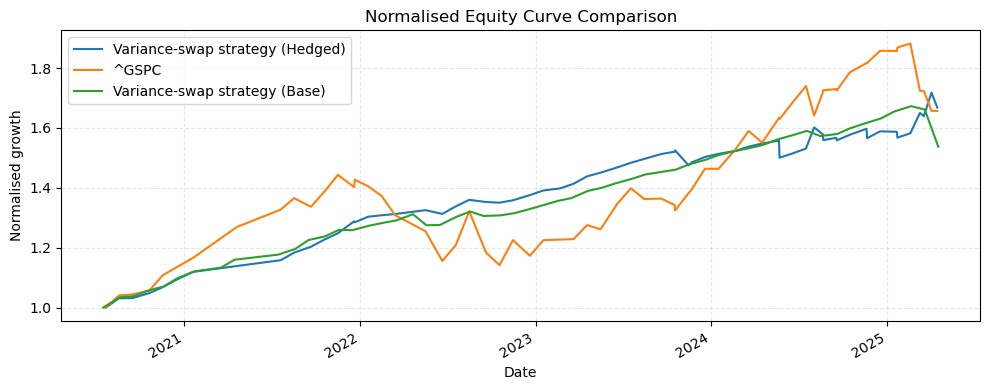

In [357]:
import glob
import pandas as pd
from pathlib import Path
import os
# ------------------------------------------------------------
# 1 ▸ generate VX-futures month codes for 2021-2025
# ------------------------------------------------------------
month_codes = ["F","G","H","J","K","M","N","Q","U","V","X","Z"]
vx_codes = [f"{m}{y}" for y in range(1,6) for m in month_codes]
# e.g. ['F1','G1',...,'Z1','F2',...'Z5']

# ------------------------------------------------------------
# 2 ▸ read every matching CSV → one DataFrame
#     file pattern assumed:  CFE_VX_<code>.csv   (e.g. CFE_VX_F4.csv)
# ------------------------------------------------------------
data_dir = "/Users/bx/Documents/Futures_strategy" 
frames   = {}

for code in vx_codes:
    file_name = f"CFE_VX_{code}.csv"
    file_path = os.path.join(data_dir, file_name)

    df = pd.read_csv(file_path, parse_dates=['Trade Date'])
    frames[code] = df


HV_THRESHOLD   = 0.40     # open long when hv_prob ≥ 60 %
FUT_PCT_EQUITY = 0.15     # risk up to 20 % of current equity
FUT_MULT       = 1000    # $ per VIX point (CFE VX spec.)
FUT_MARGIN_PCT = 0     # initial margin as % notional
STOP_PROFIT    = 0.20     # +15 % move → take profit
STOP_LOSS      = -0.5    # −5 % move  → cut loss

import calendar
from datetime import datetime, timedelta

MONTH_NUM = dict(zip("FGHJKMNQUVXZ", range(1, 13)))   # CFE codes → 1-12

def vx_expiry(code: str) -> datetime:
    """
    True final-settlement Wednesday for a VX code like 'F1', 'H3', 'Z24'.
    """
    m_code, y_code = code[0], int(code[1:])
    year = 2020 + y_code          # because your back-test spans 2021-2025
    month = MONTH_NUM[m_code]

    # following calendar month
    f_month, f_year = (1, year + 1) if month == 12 else (month + 1, year)

    # 3rd Friday of that month
    cal = calendar.monthcalendar(f_year, f_month)
    third_friday = [w[calendar.FRIDAY] for w in cal if w[calendar.FRIDAY]][2]
    third_friday = datetime(f_year, f_month, third_friday)

    # 30 days earlier (always a Wednesday by definition)
    return third_friday - timedelta(days=30)

# --------------------------------------------------------------------
# build a lookup once and keep it in memory
expiry_of = {code: vx_expiry(code) for code in frames}

def pick_contract(today: pd.Timestamp) -> tuple[str, float]:
    """
    Return (code, today's close/settle price) following the rule:
      • choose the nearest expiry *after* today
      • if that expiry − today < 7 days → skip to the next
    """
    # list of (code, expiry) that are still alive
    alive = [(c, exp) for c, exp in expiry_of.items() if exp >= today]
    if not alive:
        return None, None

    # sort by expiry
    alive.sort(key=lambda t: t[1])

    # nearest contract
    code, exp = alive[0]
    if (exp - today).days < 7 and len(alive) > 1:
        code, exp = alive[1]       # take next one instead

    # fetch the price row – fall back to NaN if missing
    f = frames[code]
    price = f.set_index("Trade Date")["Close"].reindex([today]).iloc[0]

    return code, price  

import math
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 0 ▸ daily inputs (five‑year window already in memory)
# ------------------------------------------------------------
df = features_test[["VIX_lvl"]].copy()
df["sigma_imp"]  = ((df["VIX_lvl"]/ 100.0)-0.005)                 # implied σ (dec.), with slippage
df["sigma_real"] = rv_fwd_30d.loc[df.index]               # fwd 30‑d realised σ (dec.)
df["hv_prob"]    = hv_prob.loc[df.index]
df["vix_avg5"] = df["VIX_lvl"].rolling(window=3, min_periods=3).mean()
#df = df.dropna()
#print(df)
# ------------------------------------------------------------
# 1 ▸ parameters
# ------------------------------------------------------------
CAPITAL        = 10000000           # starting equity
VEGA_PCT       = 0.30              # 30 % of capital
CONTRACT_VALUE = 10000/0.01       # $ per variance‑unit (=1 000 000)
SPREAD         = 0.005                # variance pts (0.5) bid–ask
MARGIN_RATE    = 0.0               # set >0 to reserve margin
# ------------------------------------------------------------
# 2 ▸ helper: find 3ʳᵈ Friday of each month in the index
# ------------------------------------------------------------
open_future = None
last_exit_date  = None  
fut_pnl     = [] 

rebalance_dates = [d for d in df.index
                   if d.weekday() == 1 and 15 <= d.day <= 21] #1
# print(spx_close)
# print(rebalance_dates)
# keep only dates that exist in df (already true) and within range
rebalance_dates = [d for d in rebalance_dates
                   if d >= df.index[0] and d <= df.index[-1]]

# ------------------------------------------------------------
# 3 ▸ simulation state
# ------------------------------------------------------------
equity         = CAPITAL
open_trade     = None                    # at most one active swap
realised_pnl   = []

# keep a daily close series of the index
spx_close = spx           # or however you downloaded it

def realised_variance(entry_date, maturity_date):

    window = spx_close.loc[entry_date:maturity_date]
    log_ret = np.log(window).diff().dropna()          # daily log-returns

    if log_ret.empty:                                # guard against empty slices
        return np.nan

    sigma_ann = log_ret.std(ddof=0) * np.sqrt(252)   # annualised st-dev
    return sigma_ann ** 2   

# ------------------------------------------------------------
# 4 ▸ iterate through *calendar* days
# ------------------------------------------------------------

for today in df.index:

    code_today, price_today = pick_contract(today)
    #print(price_today)
    if pd.notna(price_today) and price_today > 0.1:
        # ---- EXIT --------------------------------------------------------
        if open_future:
            # settle automatically on contract expiry if still open
            if today >= open_future["expiry"]:
                stop_hit = True   # force an exit
            else:
                ret = (price_today - open_future["entry_px"]) / open_future["entry_px"]
                stop_hit = (ret >= STOP_PROFIT) or (ret <= STOP_LOSS)

            if stop_hit:
                cash_change = open_future["contracts"] * FUT_MULT * (price_today - open_future["entry_px"])
                equity += cash_change + open_future["margin"]
                fut_pnl.append((today, cash_change))
                open_future = None
                last_exit_date = today 

        cooldown_over = (
            (last_exit_date is None)                # never traded before
            or (today - last_exit_date).days >= 7   # ≥ 7 calendar days passed
        )

        vix_today  = df.at[today, "VIX_lvl"]
        vix_avg5   = df.at[today, "vix_avg5"]

        entry_signal = (
            pd.notna(vix_avg5)  and              # wait until the rolling mean is ready
            (
                #(25 > vix_avg5 > 20  and  20 < price_today < 25) or
                (price_today < 20 and vix_avg5 < 25)
            )
        )
        # ---- ENTRY -------------------------------------------------------
        if (open_future is None) and cooldown_over and (df.at[today, "hv_prob"] >= HV_THRESHOLD) and entry_signal:

            max_cash  = equity * FUT_PCT_EQUITY
            contracts = math.floor(max_cash / (price_today * FUT_MULT))
            #print(contracts)
            if contracts:
                margin = contracts * price_today * FUT_MULT * FUT_MARGIN_PCT
                if margin <= equity:
                    equity -= margin
                    open_future = {
                        "entry_date": today,
                        "entry_px":   price_today,
                        "expiry":     expiry_of[code_today],
                        "contracts":  contracts,
                        "margin":     margin,
                    }

    # ---- settle if a trade matures today -------------------
    if open_trade and today == open_trade["maturity"]:
        # diff_var = df.at[today, "sigma_real"]**2 - open_trade["strike_var"]
        # payoff   = open_trade["contracts"] * CONTRACT_VALUE * (-diff_var)
        # print(payoff)
        # print(type(payoff))
        RV2 = realised_variance(open_trade["entry"], today)   # σ_R² for that swap
        #print(RV2)
        diff_var = open_trade["strike_var"] - RV2             # IV² – RV²
        payoff   = open_trade["contracts"] * CONTRACT_VALUE * diff_var
        payoff = payoff.iloc[0]
        # print(payoff)
        # print(type(payoff))

        realised_pnl.append((today, payoff))
        equity += payoff + open_trade["margin"]
        open_trade = None

    # ---- open / roll only on 3ʳᵈ Friday -------------------
    if today not in rebalance_dates:
        continue

    # If no forward data beyond next rebalance, stop
    curr_idx = rebalance_dates.index(today)
    if curr_idx + 1 >= len(rebalance_dates):
        break
    maturity_date = rebalance_dates[curr_idx + 1]

    # ---- size new trade -----------------------------------
    sigma_I  = df.at[today, "sigma_imp"]
    if open_future != None:
        scale = 1.0 - (df.at[today, "hv_prob"]/2)
    else:
        scale    = 1.0 #1.0 - (df.at[today, "hv_prob"])
    notional = CAPITAL * VEGA_PCT / (2 * sigma_I) * scale
    contracts = math.floor(notional / CONTRACT_VALUE)
    #print(contracts)

    if contracts <= 0:
        continue

    # optional margin reservation
    margin = contracts * CONTRACT_VALUE * MARGIN_RATE
    if margin > equity:
        continue
    equity -= margin

    strike_var = sigma_I**2 + SPREAD       # pay the offer side

    open_trade = {
        "entry":      today,
        "maturity":   maturity_date,
        "contracts":  contracts,
        "strike_var": strike_var,
        "margin":     margin
    }

# 5 ▸ results & plot
# ------------------------------------------------------------
vs_pnl  = pd.Series(dict(realised_pnl)).rename("vs_pnl")
vx_pnl  = pd.Series(dict(fut_pnl)).rename("vx_pnl")
print(vs_pnl)
print(vx_pnl)

pnl_series = (
    pd.concat([vs_pnl, vx_pnl], axis=1)
      .fillna(0)
      .sum(axis=1)
      .sort_index()
      .rename("pnl_usd")
)

cum_pnl = pnl_series.cumsum()
#print(pnl_series)
y_annual = 0.0433         
rf_daily = (1 + y_annual)**(1/252) - 1
equity_curve = (CAPITAL + cum_pnl).reindex(df.index, method="ffill").fillna(CAPITAL)
ret_d = equity_curve.pct_change().dropna()

#i.e. mean daily return
sharpe = (ret_d.mean() - rf_daily) / ret_d.std(ddof=0) * np.sqrt(252)

# # --- option B: keep the monthly frequency -------------------
# equity_lag = (CAPITAL + cum_pnl.shift()).reindex(pnl_series.index)
# ret_m = pnl_series / equity_lag

# sharpe = (ret_m.mean() - rf_monthly) / ret_m.std(ddof=1) * np.sqrt(12)

print(f"Daily Sharpe (ann.): {sharpe:5.2f}")
print(f"Final realised P&L : ${cum_pnl.iloc[-1]:,.0f}")
print(f"Open contracts     : {open_trade['contracts'] if open_trade else 0}")

equity_over_time = cum_pnl + CAPITAL

bh_price   = spx_close.loc[df.index]            # trading days only
bh_pnl     = CAPITAL * (bh_price / bh_price.iloc[0] - 1.0)
bh_equity  = CAPITAL + bh_pnl

bh_ret_d   = bh_price.pct_change().dropna()
bh_sharpe  = (bh_ret_d.mean() - rf_daily) / bh_ret_d.std(ddof=0) * np.sqrt(252)

print(bh_sharpe)

common_idx  = equity_over_time.index.intersection(bh_equity.index).sort_values()

if common_idx.empty:
    raise ValueError("The two equity series have no overlapping dates.")

start_date  = common_idx[0]                      # first day both series exist

# ---------------------------------------------------------------------------
# 2) Normalise both curves by their value on that common start date
# ---------------------------------------------------------------------------
equity_norm    = equity_over_time.loc[common_idx] / equity_over_time.loc[start_date]
bh_equity_norm = bh_equity.loc[common_idx]       / bh_equity.loc[start_date]

# ---------------------------------------------------------------------------
# 3) Plot
# ---------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 4))

equity_norm.plot(ax=ax, label="Variance-swap strategy (Hedged)")
bh_equity_norm.plot(ax=ax, label="Buy-and-hold SPX ")
equity_norm_base.plot(ax=ax, label="Variance-swap strategy (Base)")

ax.set_title("Normalised Equity Curve Comparison")
ax.set_ylabel("Normalised growth")
ax.set_xlabel("Date")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()